# Flight Data Analysis - Airbus

In [1]:
from __future__ import division

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy.stats import norm
import warnings

## I. Data Set

In [2]:
file_location = "../DataSet/Dataset_ter.xlsx"
#"../DataSet/INSA-AirbusFHS-DatasetPN_D-E-F.xlsx"
#"../DataSet/Dataset_ter.xlsx"

##### Data preprocessing :

In [3]:
def preprocessing(file_location):
    # Import data
    Removals = pd.read_excel(file_location, sheet_name='Removals')
    SNlist = pd.read_excel(file_location, sheet_name='SN list')
    airlines = pd.read_excel(file_location, sheet_name='Airlines')

    # Combining Removals and SNlist :
    fail_and_not = SNlist.copy()
    fail_and_not['On_Aircraft'] = False
    onaircraft_fan = fail_and_not['On_Aircraft']
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        onaircraft_fan[fail_and_not['Current SN Status Description']=='On Aircraft']=True
    fail_and_not['On_Aircraft'] = onaircraft_fan
    fail_and_not['failed'] = False
    failed_fan = fail_and_not['failed']
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        failed_fan[fail_and_not['Current SN Status Description']=='In Outside Repair']=True
    fail_and_not['failed'] = failed_fan
    fail_and_not = fail_and_not.drop(['Description','Current SN Status Description','Since New Date'], axis = 1)
    fail_and_not = fail_and_not.rename(columns={"Part Number": "PN", "Serial Number": "SN", "Hour ageing Since Installation": "TSI", "Hour ageing Since New": "TSN"})

    fail = Removals.copy()
    fail['On_Aircraft'] = False
    fail['failed'] = True
    failed_f = fail['failed']
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        failed_f[fail['Maintenance Type']=='Scheduled'] = False
    fail['failed'] = failed_f
    fail = fail.drop(['Removal date','Description','Maintenance Type'], axis=1)
    fail = fail.rename(columns={"P/N": "PN", "S/N": "SN", "TSI (Flight Hours) at removal": "TSI", "TSN (Flight Hours) at Removal": "TSN", "Customer":"Company"})

    all_SN = pd.unique(fail_and_not['SN'])
    SN_Removals = pd.unique(fail['SN'])

    combined = pd.concat([fail,fail_and_not], ignore_index=True)
    combined = combined.drop_duplicates(subset=['SN','PN','TSN'], keep='last')

    # Data errors treatment
    combined['TSI']=combined['TSI'].replace(np.nan, 0.0)
    combined['TSN']=combined['TSN'].replace(np.nan, 0.0)
    combined['Company']=combined['Company'].replace('1', 1)
    combined['Company']=combined['Company'].replace('3', 3)
    combined = combined[combined['TSN']!=0]
    return combined, airlines

In [4]:
combined, airlines = preprocessing(file_location)
types = pd.unique(combined["PN"])
types = types[np.logical_not(pd.isnull(types))]
print("Unit types :",types)
combined.head()

Unit types : ['C' 'B' 'A' 'C-new']


,Company,PN,SN,TSI,TSN,On_Aircraft,failed
0,3,C,15323054356,5819.0,5819.0,False,True
1,3,C,15323057041,5819.0,5819.0,False,True
2,3,C,15323072973,3036.0,3036.0,False,True
3,3,C,15323053425,5614.0,5614.0,False,True
4,3,C,15323058236,5614.0,5614.0,False,True


In [5]:
print(len(set(combined['SN'])),'/',len(combined), 'distinct SN.')

6010 / 7774 distinct SN.


## II. Data Analysis

In [6]:
data = combined.copy()
alpha = 0.05 # coefficient related to confidence levels

In [7]:
data_types = {}
for typ in types:
    data_types[typ] = data[data['PN']==typ]

In [8]:
def time_sticker(data_type): 
    T = data_type.TSI.to_numpy(dtype="float")
    d = np.array([1 if f == True else 0 for f in data_type.failed])
    return T,d

### 1. Nelson-Aalen and Kaplan-Meier estimators

We first consider the Nelson-Aalen estimator and the Kaplan-Meier estimator which will be used to compare with the model we apply for data in each cases.

(Note that we need to install the "lifelines" package for Python).

In [9]:
from lifelines import KaplanMeierFitter
from lifelines import NelsonAalenFitter

def NAF(typ,df=data_types): # Nelson_Aalen model
    data_type = df[typ]
    T,d=time_sticker(data_type)
    label = "NA-estimator of type " + typ
    return NelsonAalenFitter().fit(T,d,alpha=alpha,label=label)

def KMF(typ,df=data_types): # Kaplan_meier model
    data_type = df[typ]
    T,d=time_sticker(data_type)
    label = "KM-estimator of type " + typ
    return KaplanMeierFitter().fit(T,d,alpha=alpha,label=label)

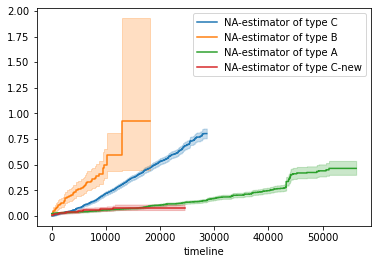

In [10]:
for typ in types:
    NAF(typ).plot(ci_show=True)

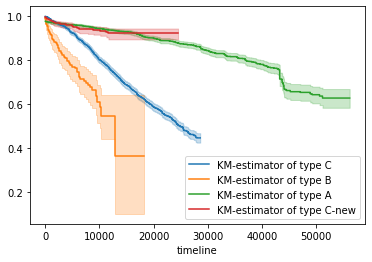

In [11]:
for typ in types:
    KMF(typ).plot(ci_show=True)

### 2. Parametric models

Find best parametric model

In [12]:
from lifelines.utils import find_best_parametric_model

def best_parametric_model(typ,df=data_types): # find the best parametric model which bases in AIC (or BIC as we can change scoring_method="BIC") method.
    data_type = df[typ]
    T,d=time_sticker(data_type)
    T[T==0]=1e-6 # Avoid divising by zero.
    tau=1-sum(d)/len(d)
    if tau>0.9:
        warnings.warn("There are more 90% censored data in type {} data. The applied model might not be correct!".format(str(typ)))
    best_model = find_best_parametric_model(T, d, scoring_method="AIC")[0]
    return best_model

Plotting best parametric model and KM-estimator:

In [13]:
def R_plot(typ): # We visualize if the best parametric model can fit the data of type "typ"
    m = best_parametric_model(typ)
    m.survival_function_.plot()
    KMF(typ).plot()
    plt.ylabel('Reliability function')
    plt.xlabel('Timeline')
    plt.title('Type ' + typ + ' data')

<ipython-input-12-1c412288dc8f>:9: UserWarning: There are more 90% censored data in type C-new data. The applied model might not be correct!
  warnings.warn("There are more 90% censored data in type {} data. The applied model might not be correct!".format(str(typ)))


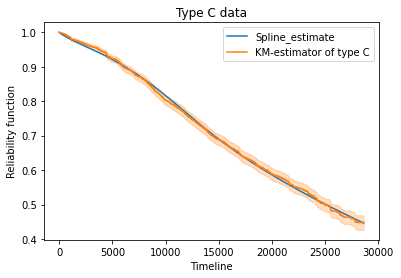

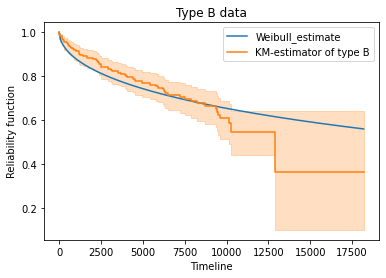

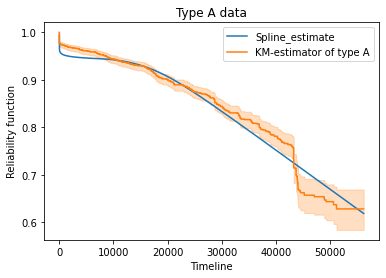

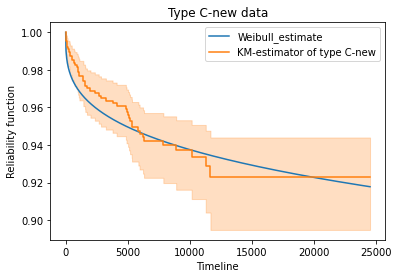

In [14]:
for typ in types:
    R_plot(typ)

## III. Homogenity test of old vs new

In order for this to work, we need to separate old parts from new ones then do a logrank test

In [15]:
from lifelines.statistics import logrank_test

def old_vs_new(typ,df=data_types):
    data_type = df[typ]
    new_or_not = data_type["TSI"]==data_type["TSN"]
    old = data_type[new_or_not==False]
    new = data_type[new_or_not==True]
    results = logrank_test(old["TSI"], new["TSI"], event_observed_A=old["failed"], event_observed_B=new["failed"])
    return results,(len(old.to_numpy()), len(new.to_numpy()))

In [16]:
for typ in types:
    print("Type %s unit test:"%typ)
    res,n = old_vs_new(typ)
    print("%d old parts vs %d new parts"%n)
    print("p_valeur = ", res.p_value)
    res.print_summary()

Type C unit test:
648 old parts vs 2669 new parts
p_valeur =  0.29624561775561525


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           1.09 0.30      1.76

Type B unit test:
208 old parts vs 83 new parts
p_valeur =  0.00018691789338992743


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          13.96 <0.005     12.39

Type A unit test:
515 old parts vs 2753 new parts
p_valeur =  2.9744223989572164e-93


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         419.61 <0.005    307.37

Type C-new unit test:
779 old parts vs 119 new parts
p_valeur =  0.605793171669508


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.27 0.61      0.72

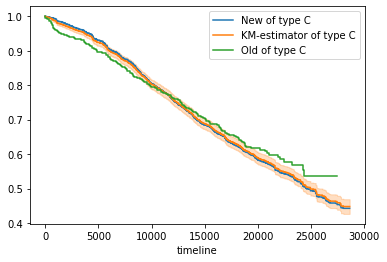

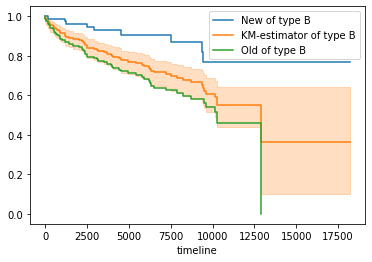

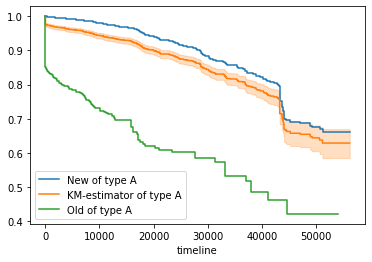

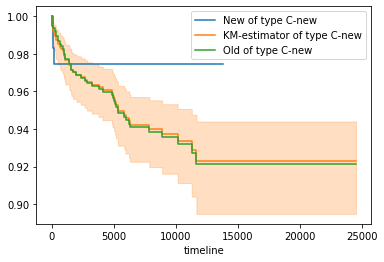

In [17]:
for typ in types:
    new_or_not = data_types[typ].TSI==data_types[typ].TSN
    
    T_old = data_types[typ][new_or_not==False]
    d_old = np.array([1 if f == True else 0 for f in T_old.failed])
    T_old = T_old.TSI.to_numpy(dtype="float")
    
    T_new = data_types[typ][new_or_not==True]
    d_new = np.array([1 if f == True else 0 for f in T_new.failed])
    T_new = T_new.TSI.to_numpy(dtype="float")
    
    KaplanMeierFitter().fit(T_new,d_new,alpha=alpha,label="New of type "+typ).plot(ci_show=False)
    KMF(typ).plot()
    KaplanMeierFitter().fit(T_old,d_old,alpha=alpha,label="Old of type "+typ).plot(ci_show=False)
    plt.show()

## IV. Simulation and stock optimization 

In [18]:
list_company = pd.unique(airlines["Company"])
list_company = list_company[np.logical_not(pd.isnull(list_company))]
print("List of companies :",list_company)
airlines

List of companies : [1 2 3 4 5 6]


,Company,Number of aircraft,FH per aircraft per month,End of contract
0,1,6,415,2024-12-01
1,2,2,310,2030-12-01
2,3,12,350,2026-12-01
3,4,5,240,2023-12-01
4,5,19,375,2026-12-01
5,6,6,350,2027-12-01


Simulation from parametric law

The idea is: for each individual SN, we simulate the number of time it will fail till the end of contract, then for large number of SN, we repeat that simulation for each individual to calculate the sum.

Simulation from kaplan Meier

In [19]:
def inverse_sampling(kapmei, timeline):
    u = np.random.uniform()
    if u < kapmei[-1]:
        T = -1
    elif u > kapmei[0]:
        T = 0
    else:
        arg = np.argmax(kapmei<=u)-1
        T = timeline[arg]+(timeline[arg+1]-timeline[arg])*(kapmei[arg]-u)/(kapmei[arg]-kapmei[arg+1])
    return T

def conditional_inverse_sampling(kapmei, timeline, TSI):
    T = 0
    while T<=TSI and T>=0:
        T = inverse_sampling(kapmei, timeline)
    return T-TSI

def num_of_fails_indivi_kapmei(TSI, T, kapmei, timeline):    
    t = conditional_inverse_sampling(kapmei, timeline, TSI)
    if t <= T:
        n_fails = 0 
        sum_t = (t<0)*np.max(timeline) + (t>=0)*t
        while sum_t <= T:
            t = inverse_sampling(kapmei, timeline)
            sum_t += (t<0)*np.max(timeline) + (t>=0)*t
            n_fails += 1
        return n_fails
    else: 
        return 0

def num_of_fails_list(TSI_list, T, kapmei, timeline):
    n_fails_list = []
    for TSI in TSI_list:
        n_fails = num_of_fails_indivi_kapmei(TSI, T, kapmei, timeline)
        n_fails_list += [n_fails]
    total_fails = np.sum(n_fails_list)
    return total_fails
    
def num_of_fails_indivi_kapmei_diff(TSI, TSN,T,k_old,t_old,k_new,t_new,rate):
    if TSI==TSN:
        t = conditional_inverse_sampling(k_new, t_new, TSI)
        cum = (t<0)*np.max(t_new)
    else:
        t = conditional_inverse_sampling(k_old, t_old, TSI)
        cum = (t<0)*np.max(t_old)
    if t <= T:
        n_fails = 0 
        sum_t = cum + (t>=0)*t
        while sum_t <= T:
            if np.random.uniform(0,1)<rate:
                t = inverse_sampling(k_old, t_old)
                sum_t += (t<0)*np.max(t_old) + (t>=0)*t
            else:
                t = inverse_sampling(k_new, t_new)
                sum_t += (t<0)*np.max(t_new) + (t>=0)*t
            n_fails += 1
        return n_fails
    else: 
        return 0

def num_of_fails_list_diff(TSI_list, TSN_list,T,k_old,t_old,k_new,t_new,rate):
    n_fails_list = []
    for i in range(len(TSI_list)):
        n_fails = num_of_fails_indivi_kapmei_diff(TSI_list[i],TSN_list[i],T,k_old,t_old,k_new,t_new,rate)
        n_fails_list += [n_fails]
    total_fails = np.sum(n_fails_list)
    return total_fails

Predicting number of failures:

In [20]:
# Confidence Intervals

def CI(Y,alpha=alpha):
    n=len(Y)
    # Confidence Interval of samples
    low1=np.quantile(Y,alpha/2)
    high1=np.quantile(Y,1-alpha/2)
    # Confidence Interval of mean (by Central Limit Theorem)
    mu=np.mean(Y)
    std=np.std(Y)
    q=norm.ppf(1-alpha/2, loc=0, scale=1)
    S=std*q/np.sqrt(n)
    low2=np.max([0.0,mu-S]) 
    high2=mu+S
    return (low1,high1),(low2,high2)

In [21]:
import datetime as dt
Today = dt.datetime.now()
repair_rate=0.8

def different_or_not(typ,df=data_types,message=False):
    r,old_new=old_vs_new(typ,df=df)
    pval=r.p_value
    diff=(pval<0.05) and (min(old_new)/sum(old_new)>=0.1)
    if diff:
        if message:
            print("The old parts and new parts of type %s have different distributions!"%typ)
    return diff

def Estimated_Stock(company,typ,year,month,df=data,df_types=data_types,airlines=airlines,Begin=Today,MC=200,rate=repair_rate):
# MC is number iteration of Monte-Carlo
    
    FH_per_month = float(airlines[airlines['Company']==company]['FH per aircraft per month'])
    End = dt.datetime(year, month, 1)
    FH_till_end = FH_per_month*((End.year-Begin.year)*12+End.month-Begin.month)
    diff = different_or_not(typ,df=df_types)
    
    if diff:
        df_types_diff = df_types.copy()
        df_types_diff.pop(typ,None)
        df_types_diff['new']=df_types[typ][df_types[typ].TSI==df_types[typ].TSN]
        df_types_diff['old']=df_types[typ][df_types[typ].TSI!=df_types[typ].TSN]
        kmf_old = KMF("old",df=df_types_diff)
        kmf_new = KMF("new",df=df_types_diff)
        surv_old = kmf_old.survival_function_.to_numpy()
        time_old = kmf_old.timeline
        surv_new = kmf_new.survival_function_.to_numpy()
        time_new = kmf_new.timeline
        if FH_till_end>np.max(time_old): 
            warnings.warn("Kaplan-Meier model of the old part of type %s can not estimate the stock until %d/%d. We apply the best parametric model to predict in this case."%(typ,month,year))
            bpm_old=best_parametric_model("old",df=df_types_diff)
            print("The best parametric model applied for old parts is:",bpm_old)
            time_old = np.linspace(0,FH_till_end,2000)
            surv_old = bpm_old.survival_function_at_times(time_old).to_numpy()

        if FH_till_end>np.max(time_new):
            warnings.warn("Kaplan-Meier model of the new part of type %s can not estimate the stock until %d/%d. We apply the best parametric model to predict in this case."%(typ,month,year))
            bpm_new=best_parametric_model("new",df=df_types_diff)
            print("The best parametric model applied for new parts is:",bpm_new)
            time_new = np.linspace(0,FH_till_end,2000)
            surv_new = bpm_new.survival_function_at_times(time_new).to_numpy()
    else:
        kmf=KMF(typ,df=df_types)
        survival = kmf.survival_function_.to_numpy()
        timeline = kmf.timeline
        if FH_till_end>np.max(timeline):
            warnings.warn("Kaplan-Meier model of type %s can not estimate the stock until %d/%d. We apply the best parametric model to predict in this case."%(typ,month,year))
            bpm = best_parametric_model(typ,df=df_types)
            print("The best parametric model applied for this type is:",bpm)
            timeline = np.linspace(0,FH_till_end,2000)
            survival = bpm.survival_function_at_times(timeline).to_numpy()

    dat = df[df.Company==company]
    dat = dat[dat.PN==typ]
    dat = dat[dat.On_Aircraft==True]
    total = len(dat.TSI)
  
    list_TSI = dat[dat.failed==False].TSI.to_numpy()
    list_TSN = dat[dat.failed==False].TSN.to_numpy()

    stock = 0
    y=[]
    for i in range(MC):
        if diff:
            a = num_of_fails_list_diff(list_TSI,list_TSN,FH_till_end,surv_old,time_old,surv_new,time_new,rate)
        else:
            a = num_of_fails_list(list_TSI,FH_till_end,survival,timeline)
        y += [a]
        stock += a
    stock = stock/MC  
    ## CI
    ci1,ci2=CI(y)
    return stock,y,ci1,ci2,total

Visualize results:

In [22]:
import time

def Result_display(company,unit_type,year,month,alpha=alpha,df=data,df_types=data_types,airlines=airlines,Begin=Today,rate=repair_rate):
    different_or_not(unit_type,message=True)
    ts = time.time()
    s,y,ci1,ci2,t = Estimated_Stock(company,unit_type,year,month,df=df,df_types=df_types,airlines=airlines,Begin=Begin,rate=rate)
    te = time.time()
    print("There are %d units of type %s of company %d which is actually on aircraft."%(t,unit_type,company))
    print("Estimated number of type %s unit in stock for company %d from %d/%d until %d/%d:"%(unit_type,company,Begin.month,Begin.year,month,year), s)
    print("with Empirical Confidence Interval (%0.2f,%0.2f), CLT Confidence Interval (%0.2f,%0.2f) at level %0.2f"%(ci1[0],ci1[1],ci2[0],ci2[1],100-100*alpha), end="")
    print("% and with repair rate is ",rate)
    print("Simulation time (by second): ", te-ts)
    plt.hist(y, bins = np.arange(int(np.min(y)-1),int(np.max(y)+1),1))
    plt.ylabel('Frequency')
    plt.xlabel('Estimated number')
    plt.show()
    y_sum = np.cumsum(y)
    moyen = y_sum/np.arange(1, len(y)+1,1)
    plt.plot(moyen)
    plt.ylabel('Estimated number')
    plt.xlabel('Monte-Carlo iteration')
    plt.show()

The old parts and new parts of type A have different distributions!
There are 719 units of type A of company 3 which is actually on aircraft.
Estimated number of type A unit in stock for company 3 from 1/2021 until 12/2022: 50.085
with Empirical Confidence Interval (36.00,64.00), CLT Confidence Interval (49.00,51.17) at level 95.00% and with repair rate is  0.8
Simulation time (by second):  6.106499910354614


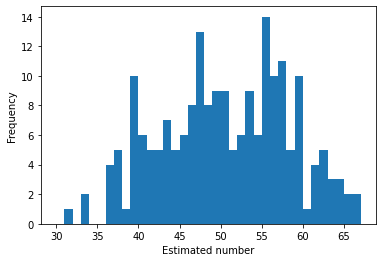

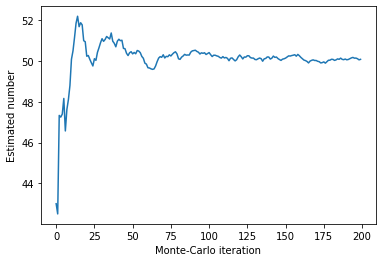

In [23]:
company=3         # must be in INTEGER
unit_type='A' # STRING
year=2022         # INTEGER
month=12           # INTEGER

Result_display(company,unit_type,year,month)

The old parts and new parts of type B have different distributions!


<ipython-input-21-92a1475442bf>:34: UserWarning: Kaplan-Meier model of the old part of type B can not estimate the stock until 6/2025. We apply the best parametric model to predict in this case.
  warnings.warn("Kaplan-Meier model of the old part of type %s can not estimate the stock until %d/%d. We apply the best parametric model to predict in this case."%(typ,month,year))


The best parametric model applied for old parts is: <lifelines.WeibullFitter:"Weibull_estimate", fitted with 208 total observations, 146 right-censored observations>


<ipython-input-21-92a1475442bf>:41: UserWarning: Kaplan-Meier model of the new part of type B can not estimate the stock until 6/2025. We apply the best parametric model to predict in this case.
  warnings.warn("Kaplan-Meier model of the new part of type %s can not estimate the stock until %d/%d. We apply the best parametric model to predict in this case."%(typ,month,year))


The best parametric model applied for new parts is: <lifelines.ExponentialFitter:"Exponential_estimate", fitted with 83 total observations, 74 right-censored observations>
There are 39 units of type B of company 3 which is actually on aircraft.
Estimated number of type B unit in stock for company 3 from 1/2021 until 6/2025: 45.39
with Empirical Confidence Interval (40.98,52.00), CLT Confidence Interval (44.94,45.84) at level 95.00% and with repair rate is  0.8
Simulation time (by second):  11.727106094360352


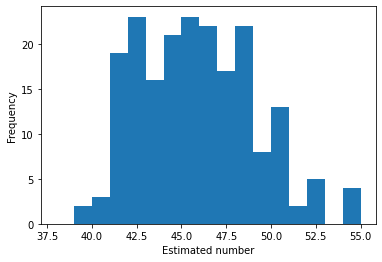

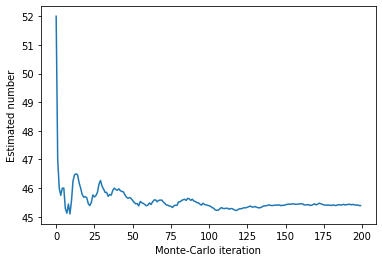

In [24]:
company=3         # must be in INTEGER
unit_type='B' # STRING
year=2025         # INTEGER
month=6           # INTEGER

Result_display(company,unit_type,year,month)

<ipython-input-21-92a1475442bf>:51: UserWarning: Kaplan-Meier model of type C-new can not estimate the stock until 6/2030. We apply the best parametric model to predict in this case.
  warnings.warn("Kaplan-Meier model of type %s can not estimate the stock until %d/%d. We apply the best parametric model to predict in this case."%(typ,month,year))
<ipython-input-12-1c412288dc8f>:9: UserWarning: There are more 90% censored data in type C-new data. The applied model might not be correct!
  warnings.warn("There are more 90% censored data in type {} data. The applied model might not be correct!".format(str(typ)))


The best parametric model applied for this type is: <lifelines.WeibullFitter:"Weibull_estimate", fitted with 898 total observations, 850 right-censored observations>
There are 813 units of type C-new of company 3 which is actually on aircraft.
Estimated number of type C-new unit in stock for company 3 from 1/2021 until 6/2030: 816.1
with Empirical Confidence Interval (813.00,820.00), CLT Confidence Interval (815.83,816.37) at level 95.00% and with repair rate is  0.8
Simulation time (by second):  13.396220684051514


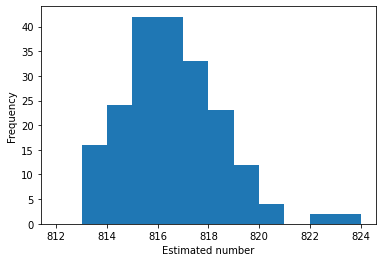

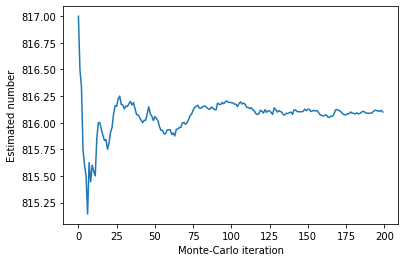

In [25]:
company=3         # must be in INTEGER
unit_type='C-new' # STRING
year=2030         # INTEGER
month=6           # INTEGER

Result_display(company,unit_type,year,month)

Estimating number of failures for all companies:

In [26]:
def Estimated_Stock_All_Companies(typ,year,month,df=data,df_types=data_types,airlines=airlines,Begin=Today,MC=200,message=False,rate=repair_rate):
    s,y,ci1,ci2,t = 0,np.zeros(MC),np.zeros(2),np.zeros(2),0
    for company in list_company:
        mm,yyyy=airlines['End of contract'][company-1].month,airlines['End of contract'][company-1].year
        if mm+yyyy*12<month+year*12:
            s_,y_,ci1_,ci2_,t_ = Estimated_Stock(company,typ,yyyy,mm,df=df,df_types=df_types,airlines=airlines,Begin=Begin,MC=MC,rate=rate)
            if message:
                print('The contract of company %d will end before %d/%d (in %d/%d)'%(company,month,year,mm,yyyy))
        else:
            s_,y_,ci1_,ci2_,t_ = Estimated_Stock(company,typ,year,month,df=df,df_types=df_types,airlines=airlines,Begin=Begin,MC=MC,rate=rate)
        s += s_
        y += y_
        ci1 += np.array(ci1_)
        ci2 += np.array(ci2_)
        t += t_
    return s,y,ci1,ci2,t

In [27]:
unit_type='A' # STRING
year=2028        # INTEGER
month=12  

ts = time.time()
s,y,ci1,ci2,t=Estimated_Stock_All_Companies(unit_type,year,month,message=True)
te = time.time()
print("Estimated number of failures : ",s)
print('Simulation time (by second): ',te-ts)

The contract of company 1 will end before 12/2028 (in 12/2024)
The contract of company 3 will end before 12/2028 (in 12/2026)
The contract of company 4 will end before 12/2028 (in 12/2023)
The contract of company 5 will end before 12/2028 (in 12/2026)
The contract of company 6 will end before 12/2028 (in 12/2027)
Estimated number of failures :  717.515
Simulation time (by second):  27.270752429962158


Estimating time that we can not afford stock:

In [28]:
service_level = 0.9

def Time_series(typ,month,year,df=data,df_types=data_types,airlines=airlines,Begin=Today,MC=200,l=6):
    start = Begin.month+Begin.year*12
    end = month+year*12
    if end<=start:
        print("Start time must be less than end time!")
        exit()
    else:
        points = np.linspace(start,end,end-start+1)
        gap=len(points)-1
        ind=[l*i for i in range(int(gap/l)+1)]+[-1]*int(gap%l!=0)
        points=np.array([points[i] for i in ind]) # assuming that number of faillures is linear for every l=6 month
        s = np.zeros(len(points))
        for i in range(len(points)):
            mois=int(points[i])%12+(int(points[i])%12==0)*12
            s[i] = Estimated_Stock_All_Companies(typ,int((points[i]-mois)/12),mois,df=df,df_types=df_types,airlines=airlines,Begin=Begin,MC=MC)[0]
    return points,s

def Estimated_time(typ,N,month,year,df=data,df_types=data_types,airlines=airlines,Begin=Today,MC=200,tau=service_level):
    P = N/tau
    x,y=Time_series(typ,month,year,df=df,df_types=df_types,airlines=airlines,Begin=Begin,MC=MC)
    if P>=np.max(y):
        pred_time = 0
    else:
        arg = np.argmin(y<=P)-1
        duration = x[arg]+(x[arg+1]-x[arg])*(y[arg]-P)/(y[arg]-y[arg+1])
        mois=int(duration)%12+(int(duration)%12==0)*12
        annee = int((duration-mois)/12)
        pred_time = dt.datetime(annee,mois,1)
    return pred_time,np.max(y)*tau-N

In [29]:
unit_type='A' # STRING
year=2021        # INTEGER
month=8
number_in_stock=20

ts = time.time()
predicted_time,r = Estimated_time(unit_type,number_in_stock,month,year)
te = time.time()
if predicted_time ==0:
    print("The number of product of type %s actually in stock is %d, which can afford immediately %0.2f"%(unit_type,number_in_stock,100*service_level),end="")
    print("%",end="")
    print(" the need of customers until %d/%d"%(month,year))
else:
    print("The number of product of type %s actually in stock is %d, which can only afford immediately %0.2f"%(unit_type,number_in_stock,100*service_level),end="")
    print("%",end="")
    print(" the need of customers until %d/%d"%(predicted_time.month,predicted_time.year))
    print("(","we are short of",round(r,2),"units to maintain this service level",").")
print("Simulation time (by second): ", te-ts)

The number of product of type A actually in stock is 20, which can only afford immediately 90.00% the need of customers until 3/2021
( we are short of 47.56 units to maintain this service level ).
Simulation time (by second):  61.952738761901855


To visualize the number of failures by time:

<ipython-input-21-92a1475442bf>:34: UserWarning: Kaplan-Meier model of the old part of type B can not estimate the stock until 1/2024. We apply the best parametric model to predict in this case.
  warnings.warn("Kaplan-Meier model of the old part of type %s can not estimate the stock until %d/%d. We apply the best parametric model to predict in this case."%(typ,month,year))


The best parametric model applied for old parts is: <lifelines.WeibullFitter:"Weibull_estimate", fitted with 208 total observations, 146 right-censored observations>


<ipython-input-21-92a1475442bf>:34: UserWarning: Kaplan-Meier model of the old part of type B can not estimate the stock until 1/2024. We apply the best parametric model to predict in this case.
  warnings.warn("Kaplan-Meier model of the old part of type %s can not estimate the stock until %d/%d. We apply the best parametric model to predict in this case."%(typ,month,year))


The best parametric model applied for old parts is: <lifelines.WeibullFitter:"Weibull_estimate", fitted with 208 total observations, 146 right-censored observations>


<ipython-input-21-92a1475442bf>:34: UserWarning: Kaplan-Meier model of the old part of type B can not estimate the stock until 7/2024. We apply the best parametric model to predict in this case.
  warnings.warn("Kaplan-Meier model of the old part of type %s can not estimate the stock until %d/%d. We apply the best parametric model to predict in this case."%(typ,month,year))


The best parametric model applied for old parts is: <lifelines.WeibullFitter:"Weibull_estimate", fitted with 208 total observations, 146 right-censored observations>


<ipython-input-21-92a1475442bf>:34: UserWarning: Kaplan-Meier model of the old part of type B can not estimate the stock until 7/2024. We apply the best parametric model to predict in this case.
  warnings.warn("Kaplan-Meier model of the old part of type %s can not estimate the stock until %d/%d. We apply the best parametric model to predict in this case."%(typ,month,year))


The best parametric model applied for old parts is: <lifelines.WeibullFitter:"Weibull_estimate", fitted with 208 total observations, 146 right-censored observations>


<ipython-input-21-92a1475442bf>:34: UserWarning: Kaplan-Meier model of the old part of type B can not estimate the stock until 7/2024. We apply the best parametric model to predict in this case.
  warnings.warn("Kaplan-Meier model of the old part of type %s can not estimate the stock until %d/%d. We apply the best parametric model to predict in this case."%(typ,month,year))


The best parametric model applied for old parts is: <lifelines.WeibullFitter:"Weibull_estimate", fitted with 208 total observations, 146 right-censored observations>


<ipython-input-21-92a1475442bf>:34: UserWarning: Kaplan-Meier model of the old part of type B can not estimate the stock until 7/2024. We apply the best parametric model to predict in this case.
  warnings.warn("Kaplan-Meier model of the old part of type %s can not estimate the stock until %d/%d. We apply the best parametric model to predict in this case."%(typ,month,year))


The best parametric model applied for old parts is: <lifelines.WeibullFitter:"Weibull_estimate", fitted with 208 total observations, 146 right-censored observations>


<ipython-input-21-92a1475442bf>:34: UserWarning: Kaplan-Meier model of the old part of type B can not estimate the stock until 7/2024. We apply the best parametric model to predict in this case.
  warnings.warn("Kaplan-Meier model of the old part of type %s can not estimate the stock until %d/%d. We apply the best parametric model to predict in this case."%(typ,month,year))


The best parametric model applied for old parts is: <lifelines.WeibullFitter:"Weibull_estimate", fitted with 208 total observations, 146 right-censored observations>


<ipython-input-21-92a1475442bf>:34: UserWarning: Kaplan-Meier model of the old part of type B can not estimate the stock until 12/2024. We apply the best parametric model to predict in this case.
  warnings.warn("Kaplan-Meier model of the old part of type %s can not estimate the stock until %d/%d. We apply the best parametric model to predict in this case."%(typ,month,year))


The best parametric model applied for old parts is: <lifelines.WeibullFitter:"Weibull_estimate", fitted with 208 total observations, 146 right-censored observations>


<ipython-input-21-92a1475442bf>:41: UserWarning: Kaplan-Meier model of the new part of type B can not estimate the stock until 12/2024. We apply the best parametric model to predict in this case.
  warnings.warn("Kaplan-Meier model of the new part of type %s can not estimate the stock until %d/%d. We apply the best parametric model to predict in this case."%(typ,month,year))


The best parametric model applied for new parts is: <lifelines.ExponentialFitter:"Exponential_estimate", fitted with 83 total observations, 74 right-censored observations>


<ipython-input-21-92a1475442bf>:34: UserWarning: Kaplan-Meier model of the old part of type B can not estimate the stock until 1/2025. We apply the best parametric model to predict in this case.
  warnings.warn("Kaplan-Meier model of the old part of type %s can not estimate the stock until %d/%d. We apply the best parametric model to predict in this case."%(typ,month,year))


The best parametric model applied for old parts is: <lifelines.WeibullFitter:"Weibull_estimate", fitted with 208 total observations, 146 right-censored observations>


<ipython-input-21-92a1475442bf>:34: UserWarning: Kaplan-Meier model of the old part of type B can not estimate the stock until 1/2025. We apply the best parametric model to predict in this case.
  warnings.warn("Kaplan-Meier model of the old part of type %s can not estimate the stock until %d/%d. We apply the best parametric model to predict in this case."%(typ,month,year))


The best parametric model applied for old parts is: <lifelines.WeibullFitter:"Weibull_estimate", fitted with 208 total observations, 146 right-censored observations>


<ipython-input-21-92a1475442bf>:34: UserWarning: Kaplan-Meier model of the old part of type B can not estimate the stock until 1/2025. We apply the best parametric model to predict in this case.
  warnings.warn("Kaplan-Meier model of the old part of type %s can not estimate the stock until %d/%d. We apply the best parametric model to predict in this case."%(typ,month,year))


The best parametric model applied for old parts is: <lifelines.WeibullFitter:"Weibull_estimate", fitted with 208 total observations, 146 right-censored observations>


<ipython-input-21-92a1475442bf>:34: UserWarning: Kaplan-Meier model of the old part of type B can not estimate the stock until 1/2025. We apply the best parametric model to predict in this case.
  warnings.warn("Kaplan-Meier model of the old part of type %s can not estimate the stock until %d/%d. We apply the best parametric model to predict in this case."%(typ,month,year))


The best parametric model applied for old parts is: <lifelines.WeibullFitter:"Weibull_estimate", fitted with 208 total observations, 146 right-censored observations>


<ipython-input-21-92a1475442bf>:34: UserWarning: Kaplan-Meier model of the old part of type B can not estimate the stock until 12/2024. We apply the best parametric model to predict in this case.
  warnings.warn("Kaplan-Meier model of the old part of type %s can not estimate the stock until %d/%d. We apply the best parametric model to predict in this case."%(typ,month,year))


The best parametric model applied for old parts is: <lifelines.WeibullFitter:"Weibull_estimate", fitted with 208 total observations, 146 right-censored observations>


<ipython-input-21-92a1475442bf>:41: UserWarning: Kaplan-Meier model of the new part of type B can not estimate the stock until 12/2024. We apply the best parametric model to predict in this case.
  warnings.warn("Kaplan-Meier model of the new part of type %s can not estimate the stock until %d/%d. We apply the best parametric model to predict in this case."%(typ,month,year))


The best parametric model applied for new parts is: <lifelines.ExponentialFitter:"Exponential_estimate", fitted with 83 total observations, 74 right-censored observations>


<ipython-input-21-92a1475442bf>:34: UserWarning: Kaplan-Meier model of the old part of type B can not estimate the stock until 7/2025. We apply the best parametric model to predict in this case.
  warnings.warn("Kaplan-Meier model of the old part of type %s can not estimate the stock until %d/%d. We apply the best parametric model to predict in this case."%(typ,month,year))


The best parametric model applied for old parts is: <lifelines.WeibullFitter:"Weibull_estimate", fitted with 208 total observations, 146 right-censored observations>


<ipython-input-21-92a1475442bf>:34: UserWarning: Kaplan-Meier model of the old part of type B can not estimate the stock until 7/2025. We apply the best parametric model to predict in this case.
  warnings.warn("Kaplan-Meier model of the old part of type %s can not estimate the stock until %d/%d. We apply the best parametric model to predict in this case."%(typ,month,year))


The best parametric model applied for old parts is: <lifelines.WeibullFitter:"Weibull_estimate", fitted with 208 total observations, 146 right-censored observations>


<ipython-input-21-92a1475442bf>:41: UserWarning: Kaplan-Meier model of the new part of type B can not estimate the stock until 7/2025. We apply the best parametric model to predict in this case.
  warnings.warn("Kaplan-Meier model of the new part of type %s can not estimate the stock until %d/%d. We apply the best parametric model to predict in this case."%(typ,month,year))


The best parametric model applied for new parts is: <lifelines.ExponentialFitter:"Exponential_estimate", fitted with 83 total observations, 74 right-censored observations>


<ipython-input-21-92a1475442bf>:34: UserWarning: Kaplan-Meier model of the old part of type B can not estimate the stock until 7/2025. We apply the best parametric model to predict in this case.
  warnings.warn("Kaplan-Meier model of the old part of type %s can not estimate the stock until %d/%d. We apply the best parametric model to predict in this case."%(typ,month,year))


The best parametric model applied for old parts is: <lifelines.WeibullFitter:"Weibull_estimate", fitted with 208 total observations, 146 right-censored observations>


<ipython-input-21-92a1475442bf>:41: UserWarning: Kaplan-Meier model of the new part of type B can not estimate the stock until 7/2025. We apply the best parametric model to predict in this case.
  warnings.warn("Kaplan-Meier model of the new part of type %s can not estimate the stock until %d/%d. We apply the best parametric model to predict in this case."%(typ,month,year))


The best parametric model applied for new parts is: <lifelines.ExponentialFitter:"Exponential_estimate", fitted with 83 total observations, 74 right-censored observations>


<ipython-input-21-92a1475442bf>:34: UserWarning: Kaplan-Meier model of the old part of type B can not estimate the stock until 7/2025. We apply the best parametric model to predict in this case.
  warnings.warn("Kaplan-Meier model of the old part of type %s can not estimate the stock until %d/%d. We apply the best parametric model to predict in this case."%(typ,month,year))


The best parametric model applied for old parts is: <lifelines.WeibullFitter:"Weibull_estimate", fitted with 208 total observations, 146 right-censored observations>


<ipython-input-21-92a1475442bf>:41: UserWarning: Kaplan-Meier model of the new part of type B can not estimate the stock until 7/2025. We apply the best parametric model to predict in this case.
  warnings.warn("Kaplan-Meier model of the new part of type %s can not estimate the stock until %d/%d. We apply the best parametric model to predict in this case."%(typ,month,year))


The best parametric model applied for new parts is: <lifelines.ExponentialFitter:"Exponential_estimate", fitted with 83 total observations, 74 right-censored observations>


<ipython-input-21-92a1475442bf>:34: UserWarning: Kaplan-Meier model of the old part of type B can not estimate the stock until 12/2024. We apply the best parametric model to predict in this case.
  warnings.warn("Kaplan-Meier model of the old part of type %s can not estimate the stock until %d/%d. We apply the best parametric model to predict in this case."%(typ,month,year))


The best parametric model applied for old parts is: <lifelines.WeibullFitter:"Weibull_estimate", fitted with 208 total observations, 146 right-censored observations>


<ipython-input-21-92a1475442bf>:41: UserWarning: Kaplan-Meier model of the new part of type B can not estimate the stock until 12/2024. We apply the best parametric model to predict in this case.
  warnings.warn("Kaplan-Meier model of the new part of type %s can not estimate the stock until %d/%d. We apply the best parametric model to predict in this case."%(typ,month,year))


The best parametric model applied for new parts is: <lifelines.ExponentialFitter:"Exponential_estimate", fitted with 83 total observations, 74 right-censored observations>


<ipython-input-21-92a1475442bf>:34: UserWarning: Kaplan-Meier model of the old part of type B can not estimate the stock until 1/2026. We apply the best parametric model to predict in this case.
  warnings.warn("Kaplan-Meier model of the old part of type %s can not estimate the stock until %d/%d. We apply the best parametric model to predict in this case."%(typ,month,year))


The best parametric model applied for old parts is: <lifelines.WeibullFitter:"Weibull_estimate", fitted with 208 total observations, 146 right-censored observations>


<ipython-input-21-92a1475442bf>:41: UserWarning: Kaplan-Meier model of the new part of type B can not estimate the stock until 1/2026. We apply the best parametric model to predict in this case.
  warnings.warn("Kaplan-Meier model of the new part of type %s can not estimate the stock until %d/%d. We apply the best parametric model to predict in this case."%(typ,month,year))


The best parametric model applied for new parts is: <lifelines.ExponentialFitter:"Exponential_estimate", fitted with 83 total observations, 74 right-censored observations>


<ipython-input-21-92a1475442bf>:34: UserWarning: Kaplan-Meier model of the old part of type B can not estimate the stock until 1/2026. We apply the best parametric model to predict in this case.
  warnings.warn("Kaplan-Meier model of the old part of type %s can not estimate the stock until %d/%d. We apply the best parametric model to predict in this case."%(typ,month,year))


The best parametric model applied for old parts is: <lifelines.WeibullFitter:"Weibull_estimate", fitted with 208 total observations, 146 right-censored observations>


<ipython-input-21-92a1475442bf>:41: UserWarning: Kaplan-Meier model of the new part of type B can not estimate the stock until 1/2026. We apply the best parametric model to predict in this case.
  warnings.warn("Kaplan-Meier model of the new part of type %s can not estimate the stock until %d/%d. We apply the best parametric model to predict in this case."%(typ,month,year))


The best parametric model applied for new parts is: <lifelines.ExponentialFitter:"Exponential_estimate", fitted with 83 total observations, 74 right-censored observations>


<ipython-input-21-92a1475442bf>:34: UserWarning: Kaplan-Meier model of the old part of type B can not estimate the stock until 1/2026. We apply the best parametric model to predict in this case.
  warnings.warn("Kaplan-Meier model of the old part of type %s can not estimate the stock until %d/%d. We apply the best parametric model to predict in this case."%(typ,month,year))


The best parametric model applied for old parts is: <lifelines.WeibullFitter:"Weibull_estimate", fitted with 208 total observations, 146 right-censored observations>


<ipython-input-21-92a1475442bf>:41: UserWarning: Kaplan-Meier model of the new part of type B can not estimate the stock until 1/2026. We apply the best parametric model to predict in this case.
  warnings.warn("Kaplan-Meier model of the new part of type %s can not estimate the stock until %d/%d. We apply the best parametric model to predict in this case."%(typ,month,year))


The best parametric model applied for new parts is: <lifelines.ExponentialFitter:"Exponential_estimate", fitted with 83 total observations, 74 right-censored observations>


<ipython-input-21-92a1475442bf>:34: UserWarning: Kaplan-Meier model of the old part of type B can not estimate the stock until 1/2026. We apply the best parametric model to predict in this case.
  warnings.warn("Kaplan-Meier model of the old part of type %s can not estimate the stock until %d/%d. We apply the best parametric model to predict in this case."%(typ,month,year))


The best parametric model applied for old parts is: <lifelines.WeibullFitter:"Weibull_estimate", fitted with 208 total observations, 146 right-censored observations>


<ipython-input-21-92a1475442bf>:41: UserWarning: Kaplan-Meier model of the new part of type B can not estimate the stock until 1/2026. We apply the best parametric model to predict in this case.
  warnings.warn("Kaplan-Meier model of the new part of type %s can not estimate the stock until %d/%d. We apply the best parametric model to predict in this case."%(typ,month,year))


The best parametric model applied for new parts is: <lifelines.ExponentialFitter:"Exponential_estimate", fitted with 83 total observations, 74 right-censored observations>


<ipython-input-21-92a1475442bf>:34: UserWarning: Kaplan-Meier model of the old part of type B can not estimate the stock until 12/2024. We apply the best parametric model to predict in this case.
  warnings.warn("Kaplan-Meier model of the old part of type %s can not estimate the stock until %d/%d. We apply the best parametric model to predict in this case."%(typ,month,year))


The best parametric model applied for old parts is: <lifelines.WeibullFitter:"Weibull_estimate", fitted with 208 total observations, 146 right-censored observations>


<ipython-input-21-92a1475442bf>:41: UserWarning: Kaplan-Meier model of the new part of type B can not estimate the stock until 12/2024. We apply the best parametric model to predict in this case.
  warnings.warn("Kaplan-Meier model of the new part of type %s can not estimate the stock until %d/%d. We apply the best parametric model to predict in this case."%(typ,month,year))


The best parametric model applied for new parts is: <lifelines.ExponentialFitter:"Exponential_estimate", fitted with 83 total observations, 74 right-censored observations>


<ipython-input-21-92a1475442bf>:34: UserWarning: Kaplan-Meier model of the old part of type B can not estimate the stock until 7/2026. We apply the best parametric model to predict in this case.
  warnings.warn("Kaplan-Meier model of the old part of type %s can not estimate the stock until %d/%d. We apply the best parametric model to predict in this case."%(typ,month,year))


The best parametric model applied for old parts is: <lifelines.WeibullFitter:"Weibull_estimate", fitted with 208 total observations, 146 right-censored observations>


<ipython-input-21-92a1475442bf>:41: UserWarning: Kaplan-Meier model of the new part of type B can not estimate the stock until 7/2026. We apply the best parametric model to predict in this case.
  warnings.warn("Kaplan-Meier model of the new part of type %s can not estimate the stock until %d/%d. We apply the best parametric model to predict in this case."%(typ,month,year))


The best parametric model applied for new parts is: <lifelines.ExponentialFitter:"Exponential_estimate", fitted with 83 total observations, 74 right-censored observations>


<ipython-input-21-92a1475442bf>:34: UserWarning: Kaplan-Meier model of the old part of type B can not estimate the stock until 7/2026. We apply the best parametric model to predict in this case.
  warnings.warn("Kaplan-Meier model of the old part of type %s can not estimate the stock until %d/%d. We apply the best parametric model to predict in this case."%(typ,month,year))


The best parametric model applied for old parts is: <lifelines.WeibullFitter:"Weibull_estimate", fitted with 208 total observations, 146 right-censored observations>


<ipython-input-21-92a1475442bf>:41: UserWarning: Kaplan-Meier model of the new part of type B can not estimate the stock until 7/2026. We apply the best parametric model to predict in this case.
  warnings.warn("Kaplan-Meier model of the new part of type %s can not estimate the stock until %d/%d. We apply the best parametric model to predict in this case."%(typ,month,year))


The best parametric model applied for new parts is: <lifelines.ExponentialFitter:"Exponential_estimate", fitted with 83 total observations, 74 right-censored observations>


<ipython-input-21-92a1475442bf>:34: UserWarning: Kaplan-Meier model of the old part of type B can not estimate the stock until 7/2026. We apply the best parametric model to predict in this case.
  warnings.warn("Kaplan-Meier model of the old part of type %s can not estimate the stock until %d/%d. We apply the best parametric model to predict in this case."%(typ,month,year))


The best parametric model applied for old parts is: <lifelines.WeibullFitter:"Weibull_estimate", fitted with 208 total observations, 146 right-censored observations>


<ipython-input-21-92a1475442bf>:41: UserWarning: Kaplan-Meier model of the new part of type B can not estimate the stock until 7/2026. We apply the best parametric model to predict in this case.
  warnings.warn("Kaplan-Meier model of the new part of type %s can not estimate the stock until %d/%d. We apply the best parametric model to predict in this case."%(typ,month,year))


The best parametric model applied for new parts is: <lifelines.ExponentialFitter:"Exponential_estimate", fitted with 83 total observations, 74 right-censored observations>


<ipython-input-21-92a1475442bf>:34: UserWarning: Kaplan-Meier model of the old part of type B can not estimate the stock until 7/2026. We apply the best parametric model to predict in this case.
  warnings.warn("Kaplan-Meier model of the old part of type %s can not estimate the stock until %d/%d. We apply the best parametric model to predict in this case."%(typ,month,year))


The best parametric model applied for old parts is: <lifelines.WeibullFitter:"Weibull_estimate", fitted with 208 total observations, 146 right-censored observations>


<ipython-input-21-92a1475442bf>:41: UserWarning: Kaplan-Meier model of the new part of type B can not estimate the stock until 7/2026. We apply the best parametric model to predict in this case.
  warnings.warn("Kaplan-Meier model of the new part of type %s can not estimate the stock until %d/%d. We apply the best parametric model to predict in this case."%(typ,month,year))


The best parametric model applied for new parts is: <lifelines.ExponentialFitter:"Exponential_estimate", fitted with 83 total observations, 74 right-censored observations>


<ipython-input-21-92a1475442bf>:34: UserWarning: Kaplan-Meier model of the old part of type B can not estimate the stock until 12/2024. We apply the best parametric model to predict in this case.
  warnings.warn("Kaplan-Meier model of the old part of type %s can not estimate the stock until %d/%d. We apply the best parametric model to predict in this case."%(typ,month,year))


The best parametric model applied for old parts is: <lifelines.WeibullFitter:"Weibull_estimate", fitted with 208 total observations, 146 right-censored observations>


<ipython-input-21-92a1475442bf>:41: UserWarning: Kaplan-Meier model of the new part of type B can not estimate the stock until 12/2024. We apply the best parametric model to predict in this case.
  warnings.warn("Kaplan-Meier model of the new part of type %s can not estimate the stock until %d/%d. We apply the best parametric model to predict in this case."%(typ,month,year))


The best parametric model applied for new parts is: <lifelines.ExponentialFitter:"Exponential_estimate", fitted with 83 total observations, 74 right-censored observations>


<ipython-input-21-92a1475442bf>:34: UserWarning: Kaplan-Meier model of the old part of type B can not estimate the stock until 1/2027. We apply the best parametric model to predict in this case.
  warnings.warn("Kaplan-Meier model of the old part of type %s can not estimate the stock until %d/%d. We apply the best parametric model to predict in this case."%(typ,month,year))


The best parametric model applied for old parts is: <lifelines.WeibullFitter:"Weibull_estimate", fitted with 208 total observations, 146 right-censored observations>


<ipython-input-21-92a1475442bf>:41: UserWarning: Kaplan-Meier model of the new part of type B can not estimate the stock until 1/2027. We apply the best parametric model to predict in this case.
  warnings.warn("Kaplan-Meier model of the new part of type %s can not estimate the stock until %d/%d. We apply the best parametric model to predict in this case."%(typ,month,year))


The best parametric model applied for new parts is: <lifelines.ExponentialFitter:"Exponential_estimate", fitted with 83 total observations, 74 right-censored observations>


<ipython-input-21-92a1475442bf>:34: UserWarning: Kaplan-Meier model of the old part of type B can not estimate the stock until 12/2026. We apply the best parametric model to predict in this case.
  warnings.warn("Kaplan-Meier model of the old part of type %s can not estimate the stock until %d/%d. We apply the best parametric model to predict in this case."%(typ,month,year))


The best parametric model applied for old parts is: <lifelines.WeibullFitter:"Weibull_estimate", fitted with 208 total observations, 146 right-censored observations>


<ipython-input-21-92a1475442bf>:41: UserWarning: Kaplan-Meier model of the new part of type B can not estimate the stock until 12/2026. We apply the best parametric model to predict in this case.
  warnings.warn("Kaplan-Meier model of the new part of type %s can not estimate the stock until %d/%d. We apply the best parametric model to predict in this case."%(typ,month,year))


The best parametric model applied for new parts is: <lifelines.ExponentialFitter:"Exponential_estimate", fitted with 83 total observations, 74 right-censored observations>


<ipython-input-21-92a1475442bf>:34: UserWarning: Kaplan-Meier model of the old part of type B can not estimate the stock until 12/2026. We apply the best parametric model to predict in this case.
  warnings.warn("Kaplan-Meier model of the old part of type %s can not estimate the stock until %d/%d. We apply the best parametric model to predict in this case."%(typ,month,year))


The best parametric model applied for old parts is: <lifelines.WeibullFitter:"Weibull_estimate", fitted with 208 total observations, 146 right-censored observations>


<ipython-input-21-92a1475442bf>:41: UserWarning: Kaplan-Meier model of the new part of type B can not estimate the stock until 12/2026. We apply the best parametric model to predict in this case.
  warnings.warn("Kaplan-Meier model of the new part of type %s can not estimate the stock until %d/%d. We apply the best parametric model to predict in this case."%(typ,month,year))


The best parametric model applied for new parts is: <lifelines.ExponentialFitter:"Exponential_estimate", fitted with 83 total observations, 74 right-censored observations>


<ipython-input-21-92a1475442bf>:34: UserWarning: Kaplan-Meier model of the old part of type B can not estimate the stock until 1/2027. We apply the best parametric model to predict in this case.
  warnings.warn("Kaplan-Meier model of the old part of type %s can not estimate the stock until %d/%d. We apply the best parametric model to predict in this case."%(typ,month,year))


The best parametric model applied for old parts is: <lifelines.WeibullFitter:"Weibull_estimate", fitted with 208 total observations, 146 right-censored observations>


<ipython-input-21-92a1475442bf>:41: UserWarning: Kaplan-Meier model of the new part of type B can not estimate the stock until 1/2027. We apply the best parametric model to predict in this case.
  warnings.warn("Kaplan-Meier model of the new part of type %s can not estimate the stock until %d/%d. We apply the best parametric model to predict in this case."%(typ,month,year))


The best parametric model applied for new parts is: <lifelines.ExponentialFitter:"Exponential_estimate", fitted with 83 total observations, 74 right-censored observations>


<ipython-input-21-92a1475442bf>:34: UserWarning: Kaplan-Meier model of the old part of type B can not estimate the stock until 12/2024. We apply the best parametric model to predict in this case.
  warnings.warn("Kaplan-Meier model of the old part of type %s can not estimate the stock until %d/%d. We apply the best parametric model to predict in this case."%(typ,month,year))


The best parametric model applied for old parts is: <lifelines.WeibullFitter:"Weibull_estimate", fitted with 208 total observations, 146 right-censored observations>


<ipython-input-21-92a1475442bf>:41: UserWarning: Kaplan-Meier model of the new part of type B can not estimate the stock until 12/2024. We apply the best parametric model to predict in this case.
  warnings.warn("Kaplan-Meier model of the new part of type %s can not estimate the stock until %d/%d. We apply the best parametric model to predict in this case."%(typ,month,year))


The best parametric model applied for new parts is: <lifelines.ExponentialFitter:"Exponential_estimate", fitted with 83 total observations, 74 right-censored observations>


<ipython-input-21-92a1475442bf>:34: UserWarning: Kaplan-Meier model of the old part of type B can not estimate the stock until 7/2027. We apply the best parametric model to predict in this case.
  warnings.warn("Kaplan-Meier model of the old part of type %s can not estimate the stock until %d/%d. We apply the best parametric model to predict in this case."%(typ,month,year))


The best parametric model applied for old parts is: <lifelines.WeibullFitter:"Weibull_estimate", fitted with 208 total observations, 146 right-censored observations>


<ipython-input-21-92a1475442bf>:41: UserWarning: Kaplan-Meier model of the new part of type B can not estimate the stock until 7/2027. We apply the best parametric model to predict in this case.
  warnings.warn("Kaplan-Meier model of the new part of type %s can not estimate the stock until %d/%d. We apply the best parametric model to predict in this case."%(typ,month,year))


The best parametric model applied for new parts is: <lifelines.ExponentialFitter:"Exponential_estimate", fitted with 83 total observations, 74 right-censored observations>


<ipython-input-21-92a1475442bf>:34: UserWarning: Kaplan-Meier model of the old part of type B can not estimate the stock until 12/2026. We apply the best parametric model to predict in this case.
  warnings.warn("Kaplan-Meier model of the old part of type %s can not estimate the stock until %d/%d. We apply the best parametric model to predict in this case."%(typ,month,year))


The best parametric model applied for old parts is: <lifelines.WeibullFitter:"Weibull_estimate", fitted with 208 total observations, 146 right-censored observations>


<ipython-input-21-92a1475442bf>:41: UserWarning: Kaplan-Meier model of the new part of type B can not estimate the stock until 12/2026. We apply the best parametric model to predict in this case.
  warnings.warn("Kaplan-Meier model of the new part of type %s can not estimate the stock until %d/%d. We apply the best parametric model to predict in this case."%(typ,month,year))


The best parametric model applied for new parts is: <lifelines.ExponentialFitter:"Exponential_estimate", fitted with 83 total observations, 74 right-censored observations>


<ipython-input-21-92a1475442bf>:34: UserWarning: Kaplan-Meier model of the old part of type B can not estimate the stock until 12/2026. We apply the best parametric model to predict in this case.
  warnings.warn("Kaplan-Meier model of the old part of type %s can not estimate the stock until %d/%d. We apply the best parametric model to predict in this case."%(typ,month,year))


The best parametric model applied for old parts is: <lifelines.WeibullFitter:"Weibull_estimate", fitted with 208 total observations, 146 right-censored observations>


<ipython-input-21-92a1475442bf>:41: UserWarning: Kaplan-Meier model of the new part of type B can not estimate the stock until 12/2026. We apply the best parametric model to predict in this case.
  warnings.warn("Kaplan-Meier model of the new part of type %s can not estimate the stock until %d/%d. We apply the best parametric model to predict in this case."%(typ,month,year))


The best parametric model applied for new parts is: <lifelines.ExponentialFitter:"Exponential_estimate", fitted with 83 total observations, 74 right-censored observations>


<ipython-input-21-92a1475442bf>:34: UserWarning: Kaplan-Meier model of the old part of type B can not estimate the stock until 7/2027. We apply the best parametric model to predict in this case.
  warnings.warn("Kaplan-Meier model of the old part of type %s can not estimate the stock until %d/%d. We apply the best parametric model to predict in this case."%(typ,month,year))


The best parametric model applied for old parts is: <lifelines.WeibullFitter:"Weibull_estimate", fitted with 208 total observations, 146 right-censored observations>


<ipython-input-21-92a1475442bf>:41: UserWarning: Kaplan-Meier model of the new part of type B can not estimate the stock until 7/2027. We apply the best parametric model to predict in this case.
  warnings.warn("Kaplan-Meier model of the new part of type %s can not estimate the stock until %d/%d. We apply the best parametric model to predict in this case."%(typ,month,year))


The best parametric model applied for new parts is: <lifelines.ExponentialFitter:"Exponential_estimate", fitted with 83 total observations, 74 right-censored observations>


<ipython-input-21-92a1475442bf>:34: UserWarning: Kaplan-Meier model of the old part of type B can not estimate the stock until 12/2024. We apply the best parametric model to predict in this case.
  warnings.warn("Kaplan-Meier model of the old part of type %s can not estimate the stock until %d/%d. We apply the best parametric model to predict in this case."%(typ,month,year))


The best parametric model applied for old parts is: <lifelines.WeibullFitter:"Weibull_estimate", fitted with 208 total observations, 146 right-censored observations>


<ipython-input-21-92a1475442bf>:41: UserWarning: Kaplan-Meier model of the new part of type B can not estimate the stock until 12/2024. We apply the best parametric model to predict in this case.
  warnings.warn("Kaplan-Meier model of the new part of type %s can not estimate the stock until %d/%d. We apply the best parametric model to predict in this case."%(typ,month,year))


The best parametric model applied for new parts is: <lifelines.ExponentialFitter:"Exponential_estimate", fitted with 83 total observations, 74 right-censored observations>


<ipython-input-21-92a1475442bf>:34: UserWarning: Kaplan-Meier model of the old part of type B can not estimate the stock until 1/2028. We apply the best parametric model to predict in this case.
  warnings.warn("Kaplan-Meier model of the old part of type %s can not estimate the stock until %d/%d. We apply the best parametric model to predict in this case."%(typ,month,year))


The best parametric model applied for old parts is: <lifelines.WeibullFitter:"Weibull_estimate", fitted with 208 total observations, 146 right-censored observations>


<ipython-input-21-92a1475442bf>:41: UserWarning: Kaplan-Meier model of the new part of type B can not estimate the stock until 1/2028. We apply the best parametric model to predict in this case.
  warnings.warn("Kaplan-Meier model of the new part of type %s can not estimate the stock until %d/%d. We apply the best parametric model to predict in this case."%(typ,month,year))


The best parametric model applied for new parts is: <lifelines.ExponentialFitter:"Exponential_estimate", fitted with 83 total observations, 74 right-censored observations>


<ipython-input-21-92a1475442bf>:34: UserWarning: Kaplan-Meier model of the old part of type B can not estimate the stock until 12/2026. We apply the best parametric model to predict in this case.
  warnings.warn("Kaplan-Meier model of the old part of type %s can not estimate the stock until %d/%d. We apply the best parametric model to predict in this case."%(typ,month,year))


The best parametric model applied for old parts is: <lifelines.WeibullFitter:"Weibull_estimate", fitted with 208 total observations, 146 right-censored observations>


<ipython-input-21-92a1475442bf>:41: UserWarning: Kaplan-Meier model of the new part of type B can not estimate the stock until 12/2026. We apply the best parametric model to predict in this case.
  warnings.warn("Kaplan-Meier model of the new part of type %s can not estimate the stock until %d/%d. We apply the best parametric model to predict in this case."%(typ,month,year))


The best parametric model applied for new parts is: <lifelines.ExponentialFitter:"Exponential_estimate", fitted with 83 total observations, 74 right-censored observations>


<ipython-input-21-92a1475442bf>:34: UserWarning: Kaplan-Meier model of the old part of type B can not estimate the stock until 12/2026. We apply the best parametric model to predict in this case.
  warnings.warn("Kaplan-Meier model of the old part of type %s can not estimate the stock until %d/%d. We apply the best parametric model to predict in this case."%(typ,month,year))


The best parametric model applied for old parts is: <lifelines.WeibullFitter:"Weibull_estimate", fitted with 208 total observations, 146 right-censored observations>


<ipython-input-21-92a1475442bf>:41: UserWarning: Kaplan-Meier model of the new part of type B can not estimate the stock until 12/2026. We apply the best parametric model to predict in this case.
  warnings.warn("Kaplan-Meier model of the new part of type %s can not estimate the stock until %d/%d. We apply the best parametric model to predict in this case."%(typ,month,year))


The best parametric model applied for new parts is: <lifelines.ExponentialFitter:"Exponential_estimate", fitted with 83 total observations, 74 right-censored observations>


<ipython-input-21-92a1475442bf>:34: UserWarning: Kaplan-Meier model of the old part of type B can not estimate the stock until 12/2027. We apply the best parametric model to predict in this case.
  warnings.warn("Kaplan-Meier model of the old part of type %s can not estimate the stock until %d/%d. We apply the best parametric model to predict in this case."%(typ,month,year))


The best parametric model applied for old parts is: <lifelines.WeibullFitter:"Weibull_estimate", fitted with 208 total observations, 146 right-censored observations>


<ipython-input-21-92a1475442bf>:41: UserWarning: Kaplan-Meier model of the new part of type B can not estimate the stock until 12/2027. We apply the best parametric model to predict in this case.
  warnings.warn("Kaplan-Meier model of the new part of type %s can not estimate the stock until %d/%d. We apply the best parametric model to predict in this case."%(typ,month,year))


The best parametric model applied for new parts is: <lifelines.ExponentialFitter:"Exponential_estimate", fitted with 83 total observations, 74 right-censored observations>


<ipython-input-21-92a1475442bf>:34: UserWarning: Kaplan-Meier model of the old part of type B can not estimate the stock until 12/2024. We apply the best parametric model to predict in this case.
  warnings.warn("Kaplan-Meier model of the old part of type %s can not estimate the stock until %d/%d. We apply the best parametric model to predict in this case."%(typ,month,year))


The best parametric model applied for old parts is: <lifelines.WeibullFitter:"Weibull_estimate", fitted with 208 total observations, 146 right-censored observations>


<ipython-input-21-92a1475442bf>:41: UserWarning: Kaplan-Meier model of the new part of type B can not estimate the stock until 12/2024. We apply the best parametric model to predict in this case.
  warnings.warn("Kaplan-Meier model of the new part of type %s can not estimate the stock until %d/%d. We apply the best parametric model to predict in this case."%(typ,month,year))


The best parametric model applied for new parts is: <lifelines.ExponentialFitter:"Exponential_estimate", fitted with 83 total observations, 74 right-censored observations>


<ipython-input-21-92a1475442bf>:34: UserWarning: Kaplan-Meier model of the old part of type B can not estimate the stock until 7/2028. We apply the best parametric model to predict in this case.
  warnings.warn("Kaplan-Meier model of the old part of type %s can not estimate the stock until %d/%d. We apply the best parametric model to predict in this case."%(typ,month,year))


The best parametric model applied for old parts is: <lifelines.WeibullFitter:"Weibull_estimate", fitted with 208 total observations, 146 right-censored observations>


<ipython-input-21-92a1475442bf>:41: UserWarning: Kaplan-Meier model of the new part of type B can not estimate the stock until 7/2028. We apply the best parametric model to predict in this case.
  warnings.warn("Kaplan-Meier model of the new part of type %s can not estimate the stock until %d/%d. We apply the best parametric model to predict in this case."%(typ,month,year))


The best parametric model applied for new parts is: <lifelines.ExponentialFitter:"Exponential_estimate", fitted with 83 total observations, 74 right-censored observations>


<ipython-input-21-92a1475442bf>:34: UserWarning: Kaplan-Meier model of the old part of type B can not estimate the stock until 12/2026. We apply the best parametric model to predict in this case.
  warnings.warn("Kaplan-Meier model of the old part of type %s can not estimate the stock until %d/%d. We apply the best parametric model to predict in this case."%(typ,month,year))


The best parametric model applied for old parts is: <lifelines.WeibullFitter:"Weibull_estimate", fitted with 208 total observations, 146 right-censored observations>


<ipython-input-21-92a1475442bf>:41: UserWarning: Kaplan-Meier model of the new part of type B can not estimate the stock until 12/2026. We apply the best parametric model to predict in this case.
  warnings.warn("Kaplan-Meier model of the new part of type %s can not estimate the stock until %d/%d. We apply the best parametric model to predict in this case."%(typ,month,year))


The best parametric model applied for new parts is: <lifelines.ExponentialFitter:"Exponential_estimate", fitted with 83 total observations, 74 right-censored observations>


<ipython-input-21-92a1475442bf>:34: UserWarning: Kaplan-Meier model of the old part of type B can not estimate the stock until 12/2026. We apply the best parametric model to predict in this case.
  warnings.warn("Kaplan-Meier model of the old part of type %s can not estimate the stock until %d/%d. We apply the best parametric model to predict in this case."%(typ,month,year))


The best parametric model applied for old parts is: <lifelines.WeibullFitter:"Weibull_estimate", fitted with 208 total observations, 146 right-censored observations>


<ipython-input-21-92a1475442bf>:41: UserWarning: Kaplan-Meier model of the new part of type B can not estimate the stock until 12/2026. We apply the best parametric model to predict in this case.
  warnings.warn("Kaplan-Meier model of the new part of type %s can not estimate the stock until %d/%d. We apply the best parametric model to predict in this case."%(typ,month,year))


The best parametric model applied for new parts is: <lifelines.ExponentialFitter:"Exponential_estimate", fitted with 83 total observations, 74 right-censored observations>


<ipython-input-21-92a1475442bf>:34: UserWarning: Kaplan-Meier model of the old part of type B can not estimate the stock until 12/2027. We apply the best parametric model to predict in this case.
  warnings.warn("Kaplan-Meier model of the old part of type %s can not estimate the stock until %d/%d. We apply the best parametric model to predict in this case."%(typ,month,year))


The best parametric model applied for old parts is: <lifelines.WeibullFitter:"Weibull_estimate", fitted with 208 total observations, 146 right-censored observations>


<ipython-input-21-92a1475442bf>:41: UserWarning: Kaplan-Meier model of the new part of type B can not estimate the stock until 12/2027. We apply the best parametric model to predict in this case.
  warnings.warn("Kaplan-Meier model of the new part of type %s can not estimate the stock until %d/%d. We apply the best parametric model to predict in this case."%(typ,month,year))


The best parametric model applied for new parts is: <lifelines.ExponentialFitter:"Exponential_estimate", fitted with 83 total observations, 74 right-censored observations>


<ipython-input-21-92a1475442bf>:34: UserWarning: Kaplan-Meier model of the old part of type B can not estimate the stock until 12/2024. We apply the best parametric model to predict in this case.
  warnings.warn("Kaplan-Meier model of the old part of type %s can not estimate the stock until %d/%d. We apply the best parametric model to predict in this case."%(typ,month,year))


The best parametric model applied for old parts is: <lifelines.WeibullFitter:"Weibull_estimate", fitted with 208 total observations, 146 right-censored observations>


<ipython-input-21-92a1475442bf>:41: UserWarning: Kaplan-Meier model of the new part of type B can not estimate the stock until 12/2024. We apply the best parametric model to predict in this case.
  warnings.warn("Kaplan-Meier model of the new part of type %s can not estimate the stock until %d/%d. We apply the best parametric model to predict in this case."%(typ,month,year))


The best parametric model applied for new parts is: <lifelines.ExponentialFitter:"Exponential_estimate", fitted with 83 total observations, 74 right-censored observations>


<ipython-input-21-92a1475442bf>:34: UserWarning: Kaplan-Meier model of the old part of type B can not estimate the stock until 12/2028. We apply the best parametric model to predict in this case.
  warnings.warn("Kaplan-Meier model of the old part of type %s can not estimate the stock until %d/%d. We apply the best parametric model to predict in this case."%(typ,month,year))


The best parametric model applied for old parts is: <lifelines.WeibullFitter:"Weibull_estimate", fitted with 208 total observations, 146 right-censored observations>


<ipython-input-21-92a1475442bf>:41: UserWarning: Kaplan-Meier model of the new part of type B can not estimate the stock until 12/2028. We apply the best parametric model to predict in this case.
  warnings.warn("Kaplan-Meier model of the new part of type %s can not estimate the stock until %d/%d. We apply the best parametric model to predict in this case."%(typ,month,year))


The best parametric model applied for new parts is: <lifelines.ExponentialFitter:"Exponential_estimate", fitted with 83 total observations, 74 right-censored observations>


<ipython-input-21-92a1475442bf>:34: UserWarning: Kaplan-Meier model of the old part of type B can not estimate the stock until 12/2026. We apply the best parametric model to predict in this case.
  warnings.warn("Kaplan-Meier model of the old part of type %s can not estimate the stock until %d/%d. We apply the best parametric model to predict in this case."%(typ,month,year))


The best parametric model applied for old parts is: <lifelines.WeibullFitter:"Weibull_estimate", fitted with 208 total observations, 146 right-censored observations>


<ipython-input-21-92a1475442bf>:41: UserWarning: Kaplan-Meier model of the new part of type B can not estimate the stock until 12/2026. We apply the best parametric model to predict in this case.
  warnings.warn("Kaplan-Meier model of the new part of type %s can not estimate the stock until %d/%d. We apply the best parametric model to predict in this case."%(typ,month,year))


The best parametric model applied for new parts is: <lifelines.ExponentialFitter:"Exponential_estimate", fitted with 83 total observations, 74 right-censored observations>


<ipython-input-21-92a1475442bf>:34: UserWarning: Kaplan-Meier model of the old part of type B can not estimate the stock until 12/2026. We apply the best parametric model to predict in this case.
  warnings.warn("Kaplan-Meier model of the old part of type %s can not estimate the stock until %d/%d. We apply the best parametric model to predict in this case."%(typ,month,year))


The best parametric model applied for old parts is: <lifelines.WeibullFitter:"Weibull_estimate", fitted with 208 total observations, 146 right-censored observations>


<ipython-input-21-92a1475442bf>:41: UserWarning: Kaplan-Meier model of the new part of type B can not estimate the stock until 12/2026. We apply the best parametric model to predict in this case.
  warnings.warn("Kaplan-Meier model of the new part of type %s can not estimate the stock until %d/%d. We apply the best parametric model to predict in this case."%(typ,month,year))


The best parametric model applied for new parts is: <lifelines.ExponentialFitter:"Exponential_estimate", fitted with 83 total observations, 74 right-censored observations>


<ipython-input-21-92a1475442bf>:34: UserWarning: Kaplan-Meier model of the old part of type B can not estimate the stock until 12/2027. We apply the best parametric model to predict in this case.
  warnings.warn("Kaplan-Meier model of the old part of type %s can not estimate the stock until %d/%d. We apply the best parametric model to predict in this case."%(typ,month,year))


The best parametric model applied for old parts is: <lifelines.WeibullFitter:"Weibull_estimate", fitted with 208 total observations, 146 right-censored observations>


<ipython-input-21-92a1475442bf>:41: UserWarning: Kaplan-Meier model of the new part of type B can not estimate the stock until 12/2027. We apply the best parametric model to predict in this case.
  warnings.warn("Kaplan-Meier model of the new part of type %s can not estimate the stock until %d/%d. We apply the best parametric model to predict in this case."%(typ,month,year))


The best parametric model applied for new parts is: <lifelines.ExponentialFitter:"Exponential_estimate", fitted with 83 total observations, 74 right-censored observations>


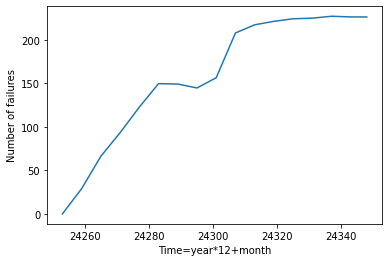

Simulation time (by second): 552.5473806858063


In [30]:
unit_type='B' # STRING
year=2028        # INTEGER
month=12  
gap=6

ts = time.time()
x,y=Time_series(unit_type,month,year)
te = time.time()
plt.show()
plt.plot(x,y)
plt.ylabel('Number of failures')
plt.xlabel('Time=year*12+month')
plt.show()
print('Simulation time (by second):',te-ts)

## V. Test-Validation:

In [31]:
file_test = "../DataSet/Datatest_until_Dec-2018.xlsx"
# "../INSA-Airbus FHS - Data set PN_C Dec-18.xlsx"
combined_test, air_test = preprocessing(file_test)
types_test = pd.unique(combined_test["PN"])
types_test = types_test[np.logical_not(pd.isnull(types_test))]
print("Unit types :",types_test)
combined_test.head()

Unit types : ['C' 'B' 'A' 'C-new']


,Company,PN,SN,TSI,TSN,On_Aircraft,failed
0,3,C,15323054356,5819.0,5819.0,False,True
1,3,C,15323057041,5819.0,5819.0,False,True
2,3,C,15323072973,3036.0,3036.0,False,True
3,3,C,15323053425,5614.0,5614.0,False,True
4,3,C,15323058236,5614.0,5614.0,False,True


In [32]:
print(len(set(combined_test['SN'])),'/',len(combined_test), 'distinct SN.')

5630 / 7015 distinct SN.


In [33]:
data_test = combined_test.copy()
data_test_types = {}
for typ in types_test:
    data_test_types[typ] = data_test[data_test['PN']==typ]

In [34]:
air_test

,Company,Number of aircraft,FH per aircraft per month,End of contract
0,1,6,415,2024-12-01
1,2,2,310,2030-12-01
2,3,12,350,2026-12-01
3,4,5,240,2023-12-01
4,5,19,375,2026-12-01
5,6,6,350,2027-12-01


The old parts and new parts of type A have different distributions!
There are 1128 units of type A of company 5 which is actually on aircraft.
Estimated number of type A unit in stock for company 5 from 12/2018 until 12/2020: 89.825
with Empirical Confidence Interval (71.00,110.00), CLT Confidence Interval (88.43,91.22) at level 95.00% and with repair rate is  0.8
Simulation time (by second):  8.696680545806885


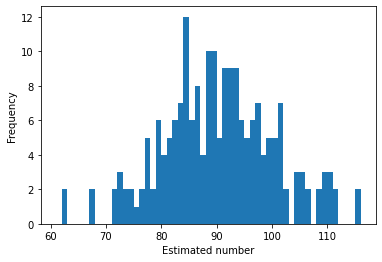

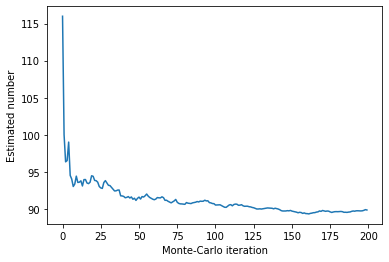

In [35]:
company=5         # must be in INTEGER
unit_type='A' # STRING
year=2020         # INTEGER
month=12           # INTEGER

date_test = dt.datetime(2018,12,1)
Result_display(company,unit_type,year,month,df=data_test,df_types=data_test_types,airlines=air_test,Begin=date_test)

In [36]:
table_18 = data_test[data_test.PN=='A']
table_18 = table_18[table_18.Company==5]
table_18 = table_18[table_18.failed==True]
print("Number of fail in 2018 : ", len(table_18))
table_20 = data[data.PN=='A']
table_20 = table_20[table_20.Company==5]
table_20 = table_20[table_20.failed==True]
print("Number of fail in 2020 : ", len(table_20))
print("Number of fail from 12/2018 to 12/2020 in reality : ",len(table_20)-len(table_18))

Number of fail in 2018 :  206
Number of fail in 2020 :  271
Number of fail from 12/2018 to 12/2020 in reality :  65


Test for all companies

In [37]:
unit_type='A' # STRING
year=2020         # INTEGER
month=12           # INTEGER

date_test = dt.datetime(2018,12,1)
s,y,ci1,ci2,t = Estimated_Stock_All_Companies(unit_type,year,month,df=data_test,df_types=data_test_types,airlines=air_test,Begin=date_test)
print("Number of failures in average by simulation : ", s)
print("Confidence Interval : ",ci1)

Number of failures in average by simulation :  152.99
Confidence Interval :  [104.95  207.075]


In [38]:
table_18 = data_test[data_test.PN=='A']
table_18 = table_18[table_18.failed==True]
print("Number of fail in 2018 : ", len(table_18))
table_20 = data[data.PN=='A']
table_20 = table_20[table_20.failed==True]
print("Number of fail in 2020 : ", len(table_20))
print("Number of fail from 12/2018 to 12/2020 in reality : ",len(table_20)-len(table_18))

Number of fail in 2018 :  317
Number of fail in 2020 :  507
Number of fail from 12/2018 to 12/2020 in reality :  190
